In [1]:
%matplotlib inline
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import time as time

import network.capture as capture


In [2]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

training_data = list(training_data)
validation_data = list(validation_data)
test_data = list(test_data)

#bigNetwork: 784x392x196x196x10 neurons
#smallNetwork: 784x100x10 neurnsta)

with open('network/bigNetwork.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

net.biases = list(map(cp.array,net.biases))
net.weights = list(map(cp.array,net.weights))

In [3]:
def train_new_network():

    start = time.time()

    newNet = Network.Network([392,392,1966,98,10])
    newNet.SGD(training_data, 30, 100, 10, test_data=test_data)

    end = time.time()
    print(end - start) 

    
    with open('network/newNet.pkl', 'rb') as file:
        pickle.dump(newNet, file)
    return newNet

def evaluateNet(net):
    print("start eval")

    start = time.time()

    print(net.evaluate(test_data))

    print("took " + str(round(time.time() - start,2)) + "seconds")
evaluateNet(net)

start eval
9577
took 5.45seconds


In [4]:

with open('network/pattern.pkl', 'rb') as pattern_file:
  u_pattern = pickle._Unpickler(pattern_file)
  u_pattern.encoding = 'latin1'
  pattern= u_pattern.load()

#generate new patterns (inefficient implementation and might take a long time)
#    
#pattern = net.extract_src_pattern(test
#with open('network/newPattern.pkl', 'wb') as file2:  
#       pickle.dump(pattern, file2)_data)

def print_pattern(pattern):
    # print(pattern)

    l = []
    for min, max in pattern:
        # this is the function that aggregates the tuple of src activations
        # might change this to better display the intervallsin pattern:
        l.append(max+min);
    l = list(map(cp.asnumpy,l))
    l = np.stack(l)
    l = l.res
    plt.imshow(l)
    plt.show()

In [5]:
#print all patterns
#
#for i in range(0,10#):
   #print_pattern(pattern[i])

[[0.  ] [0.  ] [0.  ] [0.  ] [0.  ] [0.98] [0.  ] [0.  ] [0.  ] [0.  ]]
Network prediction: 5

out-of-bounds activations: 5


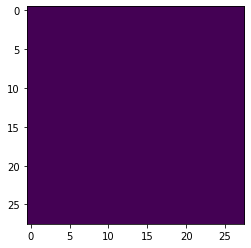

In [6]:
# start live-classification
# need to specifiy the video source within the function
# exit by pressing q in the opened window

capture.capturenow(net,pattern)


Below are some functions provided by the source project

In [7]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+cp.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [cp.zeros(b.shape) for b in net.biases]
    nabla_w = [cp.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = cp.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = cp.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = cp.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = cp.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = cp.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = cp.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
   
    a = adversarial(net, n, 10000, 3)
    x = cp.round(net.feedforward(a), 2)
    print(str(np.round(x, 2)).replace("\n",""))
    print('Network prediction: ' + str(cp.argmax(x)) + '\n')
    net.evaluate_src_pattern(pattern,a)

    
    print('Adversarial Example: ')
    plt.imshow(np.reshape(cp.asnumpy(a),(28,28)), cmap='viridis')


[[0.01] [0.  ] [0.  ] [0.  ] [0.  ] [0.  ] [0.98] [0.  ] [0.  ] [0.  ]]
Network prediction: 6

out-of-bounds activations: 142
Adversarial Example: 


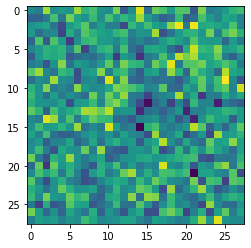

In [8]:
# generate a attack pattern for specified label
# can yield poor results with big network due to small learning rate / iteration count 
generate(6)

In [9]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = cp.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = cp.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in cp.arange(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!

        x -= eta * (d+lam * (x-x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,9999)

    while test_data[idx][1] != m:
        idx += 1
    
    a = sneaky_adversarial(net, n, test_data[idx][0], 10000, 3)
    x = cp.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(np.reshape(cp.asnumpy(test_data[idx][0]),(28,28)), cmap='viridis')

    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(np.reshape(cp.asnumpy(a),(28,28)), cmap='viridis')
    plt.show()
    print(str(np.round(x, 2)).replace("\n",""))
    print('Network prediction: ' + str(cp.argmax(a)) + '\n')
    net.evaluate_src_pattern(pattern,a)

    return a


What we want our adversarial example to look like: 


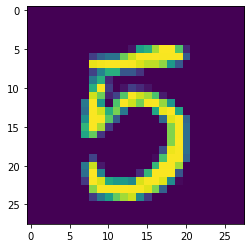



Adversarial Example: 


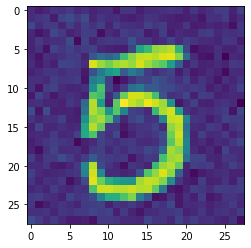

[[0.] [0.] [0.] [1.] [0.] [0.] [0.] [0.] [0.] [0.]]
Network prediction: 348

out-of-bounds activations: 2


In [13]:
# sneaky_generate(target label, target digit)
# generate adversarial examples
# some pairs work better than other
adv_ex = sneaky_generate(3,5)

In [ ]:
def augment_data(n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    """
    # Our augmented training set:
    augmented = []
    
    for i in cp.arange(n):
        # Progress "bar"
        if i % 100 == 0:
            print("Generated digits: " + str(i))
            
        # Randomly choose a digit that the example will look like
        rnd_actual_digit = np.random.randint(10)
        
        # Find random instance of rnd_actual_digit in the training set
        rnd_actual_idx = np.random.randint(len(data))
        while cp.argmax(data[rnd_actual_idx][1]) != rnd_actual_digit:
            rnd_actual_idx = np.random.randint(len(data))
        x_target = data[rnd_actual_idx][0]
        
        # Choose value for adversarial attack
        rnd_fake_digit = cp.random.randint(10)
        
        # Generate adversarial example
        x_adversarial = sneaky_adversarial(net, rnd_fake_digit, x_target, steps, 1)
        
        # Add new data
        y_actual = data[rnd_actual_idx][1]
        
        augmented.append((x_adversarial, y_actual))
        
    return augmented

In [ ]:
# generate augmented data set
# This will take quite a while ~(20 min per 10000)
augmented = augment_data(10000, training_data, 100)

In [ ]:
def check_augmented(i, augmented):
    # Show image
    print('Image: \n')
    plt.imshow(np.reshape(cp.asnumpy(augmented[i][0]),(28,28)), cmap='viridis')
    plt.show()
    
    # Show original network prediction
    print('Original network prediction: \n')
    print(cp.round(net.feedforward(augmented[i][0]), 2))
    
    # Show label
    print('\nLabel: \n')
    print(augmented[i][1])

# check i^th adversarial image
check_augmented(853, augmented)

In [ ]:
# Create new network
net2 = Network.Network([784,392,196,196,10])

# Train on augmented + original training set
net2.SGD(augmented + training_data, 30, 100, 10, test_data=test_data)

Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [ ]:
print("first network:")
evaluateNet(net)

print("\nsecond network:")
evaluateNet(net2)